# Forecasting attendances until 2040

## IMPORT PACKAGES

In [16]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('attendances_2016_2024.csv')
df.head()

,Date,A&E attendances Type 1,A&E attendances Type 2,A&E attendances Other A&E Department,Total A&E attendances
0,01/06/2015,"7,036",0,773,7809
1,01/07/2015,"7,422",0,777,8199
2,01/08/2015,"7,440",0,616,8056
3,01/09/2015,"7,340",0,733,8073
4,01/10/2015,"7,536",0,740,8276


In [18]:
#subset totals
data=df[['Date','Total A&E attendances']]

## Prophet Decomposition

In [19]:
# lockdowns in the UK as defined by the goverment
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-23', 'lower_window': 0,'ds_upper': '2021-03-28'}
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-23,0,2021-03-28,370


C:\Users\mifab\AppData\Local\Temp\ipykernel_27968\380962491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')  # Convert date column
C:\Users\mifab\AppData\Local\Temp\ipykernel_27968\380962491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total A&E attendances'] = (
09:13:59 - cmdstanpy - INFO - Chain [1] start processing
09:14:00 - cmdstanpy - INFO - Chain [1] done processing


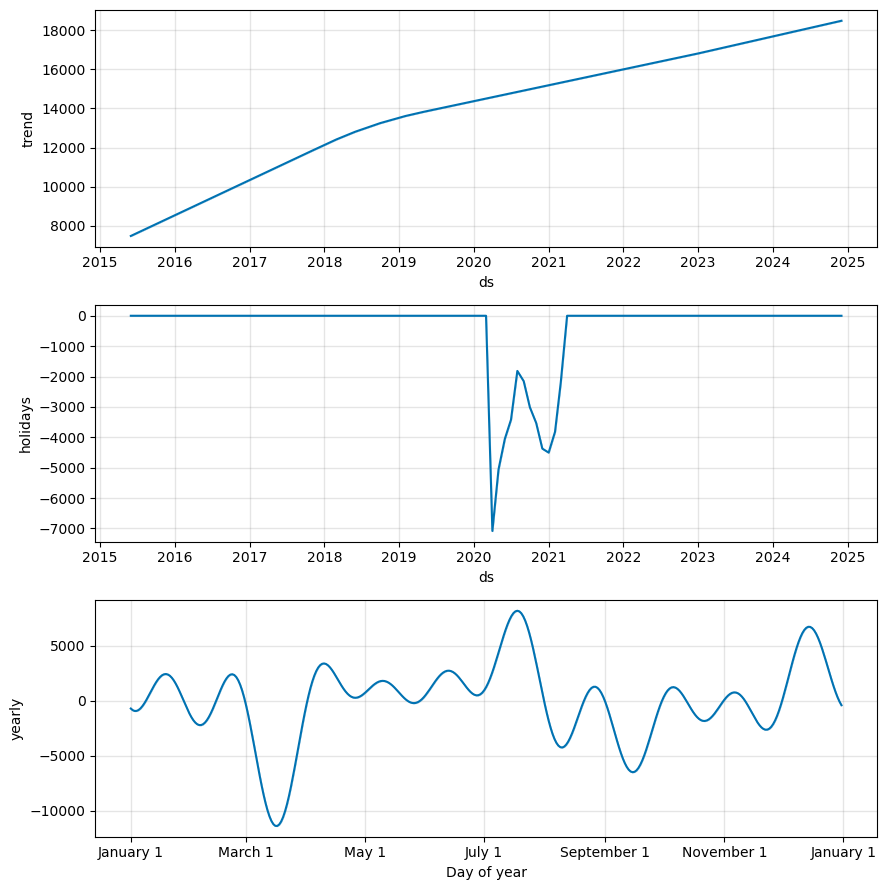

In [20]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')  # Convert date column
data['Total A&E attendances'] = (
    data['Total A&E attendances'].astype(str).str.replace(',', '').astype(int)  # Convert to numeric
)

# Rename columns for Prophet
data_prepared = data.rename(columns={'Date': 'ds', 'Total A&E attendances': 'y'})

# Initialise and fit the Prophet model
model = Prophet(holidays=lockdowns)
model.fit(data_prepared)

# Forecast and decompose
future = model.make_future_dataframe(periods=0)  # No forecasting, only decomposition
forecast = model.predict(future)

# Plot the components: trend, seasonality, and residuals
model.plot_components(forecast)
plt.show()

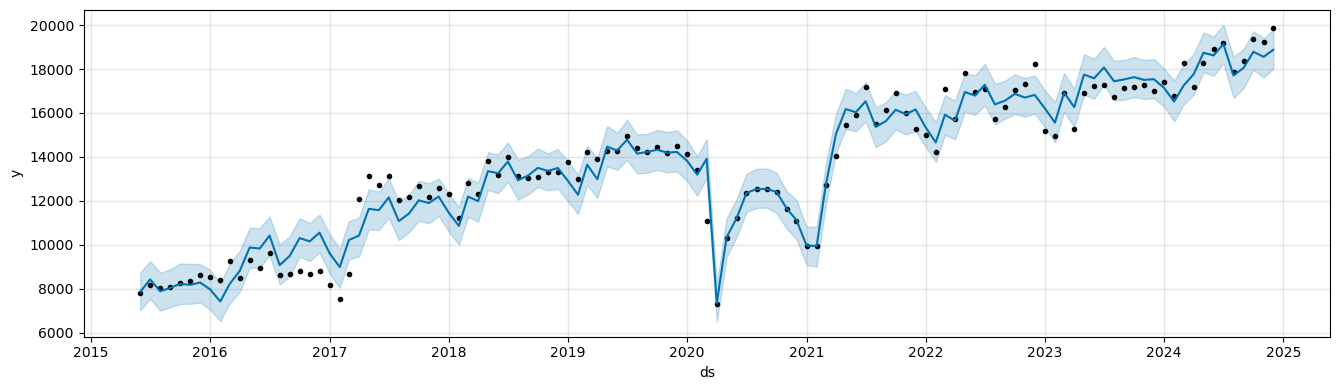

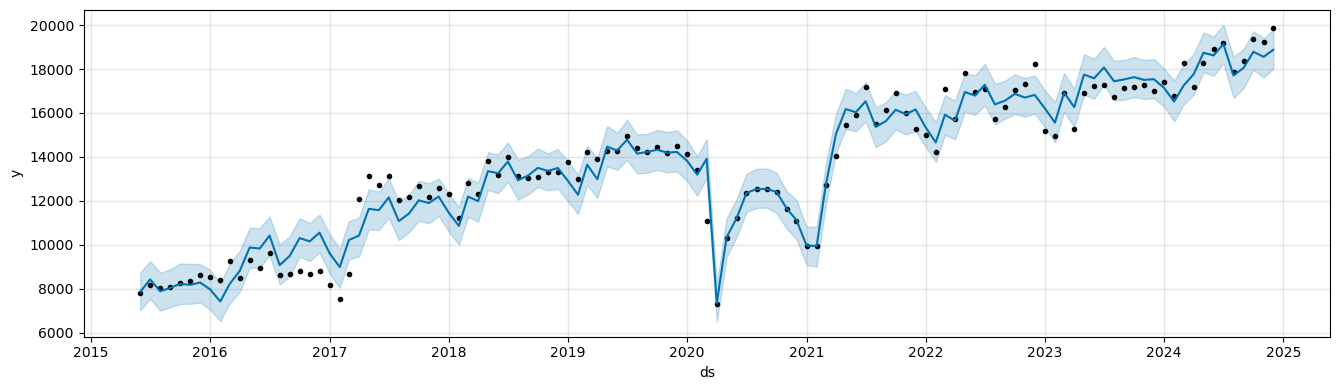

In [22]:
model.plot(forecast,figsize=(13.5, 4))

## MONTE CARLO Forecasting

In [23]:
#format and group data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
yearly_data=data.groupby(data.Date.dt.year).sum().reset_index()[1:]
yearly_data['Date'] = pd.to_datetime(yearly_data['Date'], format='%Y')

C:\Users\mifab\AppData\Local\Temp\ipykernel_27968\580089884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')


In [24]:
# Example: Historical A&E attendances from 2016 to 2024 (replace with your actual data)
historical_years = np.array(yearly_data.Date)
historical_attendances = np.array(yearly_data["Total A&E attendances"])  # Including COVID drop in 2020 and 2021a

# Constants
population_2022 = 907660  # Population in 2022
population_2041 = 1059570  # Population in 2041
years = np.arange(2024, 2042)  # Time from 2024 to 2041 (forecast period)

In [25]:
max_attendance_percentage=historical_attendances[-3]*100/population_2022
max_attendance_percentage

21.86743934953617

In [26]:
# Calculate growth rates
# Growth rate for 2016-2019 (pre-COVID) -- between 2016-2017, 2017-2018, and 2018-2019
growth_rate_pre_covid = (historical_attendances[1:4] - historical_attendances[:3]) / historical_attendances[:3]

# Growth rate for 2022-2024 (post-COVID)
growth_rate_post_covid = (historical_attendances[6:8] - historical_attendances[5:7]) / historical_attendances[5:7]

#combine both growth rates by taking a weighted average or simply using both sets of growth rates
combined_growth_rates = np.concatenate([growth_rate_pre_covid, growth_rate_post_covid])
# Estimate the average and standard deviation of the growth rate (from 2016-2019)
mean_growth_rate = np.mean(combined_growth_rates)
std_dev_growth_rate = np.std(combined_growth_rates)

# Population growth rate for 2024-2041 (calculated from known population figures)
population_growth_rate = np.log(population_2041 / population_2022) / (2041 - 2022)

# Number of simulations (Monte Carlo iterations)
num_simulations = 1000

# Prepare an array to store the results
simulated_attendances = np.zeros((num_simulations, len(years)))

# Correct the starting value for N_2024, which should be based on 2024 attendance (not 2022)
N_2024 = historical_attendances[-1]  # Attendance in 2024 (historical data)

In [27]:
# Monte Carlo Simulation to forecast A&E attendances based on historical growth and population growth
for i in range(num_simulations):
    # Random growth rate for A&E attendances using mean and std from historical growth rates
    r = np.random.normal(mean_growth_rate, std_dev_growth_rate)
    
    # Calculate attendances for each year using the historical growth rates and population growth
    for t_idx, t in enumerate(years):
        # Forecast the attendance for the current year using the random growth rate and population growth
        if t_idx == 0:
            # Start the forecast at the 2024 value (last historical data point)
            simulated_attendances[i, t_idx] = N_2024
        else:
            # Apply the random growth rate and population growth factor to the previous year's forecast
            population_growth_factor = np.exp(population_growth_rate * (t - 2022))  # Population growth factor
            
            population_for_year = population_2022 * population_growth_factor  # Population for the year
            
            # Logarithmic growth function to simulate saturation
            predicted_attendance = simulated_attendances[i, t_idx - 1] * (1 + r) * population_growth_factor
            
            # Dynamically adjust the saturation point to ensure earlier saturation
            saturation_point_factor = 1 - (t - 2022)  # Adjust this for each year
            saturation_point_factor = max(saturation_point_factor, 0.1)  # Prevent it from becoming negative
            
            saturation_point = population_for_year * max_attendance_percentage * saturation_point_factor  # Dynamic saturation
            
            # Apply the logarithmic saturation formula: ln(1 + x) to ensure growth slows down over time
            predicted_attendance = saturation_point * np.log(1 + predicted_attendance / saturation_point)
            
            # Store the result in the simulation matrix
            simulated_attendances[i, t_idx] = predicted_attendance
            
# Calculate the mean and 95% confidence intervals for the forecast
mean_attendance = np.mean(simulated_attendances, axis=0)
lower_bound = np.percentile(simulated_attendances, 2.5, axis=0)
upper_bound = np.percentile(simulated_attendances, 97.5, axis=0)

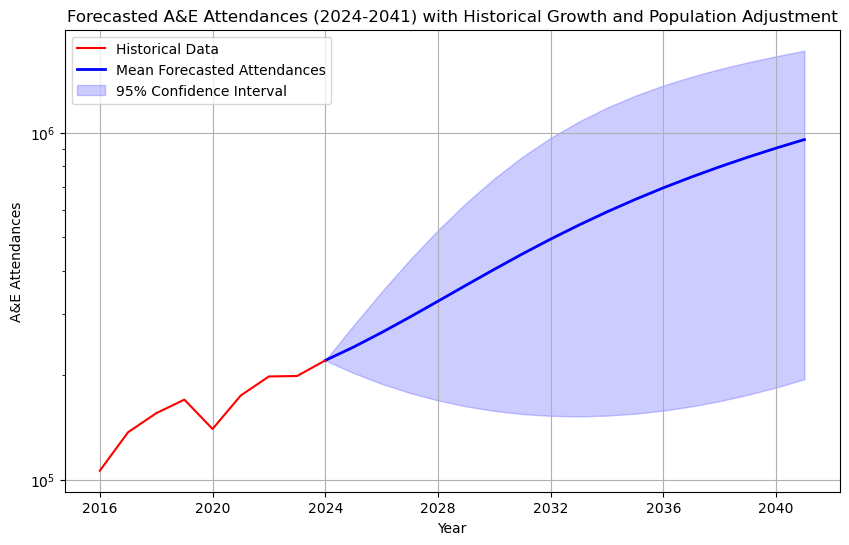

In [28]:
#fix for plot
years=pd.to_datetime(years, format='%Y')

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the historical data (2016-2024)
plt.plot(historical_years, historical_attendances, color='red', label="Historical Data", zorder=5)

# Plot the forecasted data (2024-2041) as a line
plt.plot(years, mean_attendance, label="Mean Forecasted Attendances", color='blue', linewidth=2)

# Plot the confidence interval as shaded region
plt.fill_between(years, lower_bound, upper_bound, color='blue', alpha=0.2, label="95% Confidence Interval")

# Titles and labels
plt.title("Forecasted A&E Attendances (2024-2041) with Historical Growth and Population Adjustment")
plt.xlabel("Year")
plt.ylabel("A&E Attendances")
plt.legend(loc='upper left')
plt.yscale('log',base=10) 
# Add grid and show the plot
plt.grid(True)
plt.show()

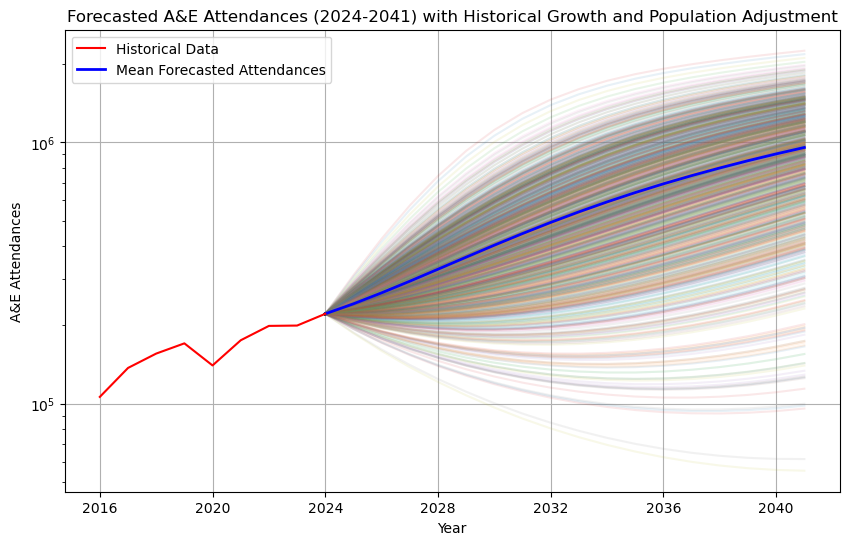

In [29]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot the historical data (2016-2024)
plt.plot(historical_years, historical_attendances, color='red', label="Historical Data", zorder=5)

# Plot each individual simulation as a line
for i in range(num_simulations):
    plt.plot(years, simulated_attendances[i], alpha=0.1)  # Light blue lines for each simulation
    
# Plot the forecasted data (2024-2041) as a line
plt.plot(years, mean_attendance, label="Mean Forecasted Attendances", color='blue', linewidth=2)

# Titles and labels
plt.title("Forecasted A&E Attendances (2024-2041) with Historical Growth and Population Adjustment")
plt.xlabel("Year")
plt.ylabel("A&E Attendances")
plt.legend()
plt.yscale('log',base=10) 
# Add grid and show the plot
plt.grid(True)
plt.show()